# 09-01: Supervised Classification with Logistic Regression

*June 26 2024*  

In the first practice session, we introduce binary statistical classification with logistic regression. We show how we can estimate the parameters of the model using a gradient ascent algorithm.

In [1]:
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
from scipy.special import expit
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import sklearn.metrics

from mpl_toolkits.mplot3d import Axes3D

plt.style.use('default')
sns.set_style("whitegrid")

## Generating synthetic data

We consider a maximally simple example, where we want to assign binary classes 0 and 1 based on a single real-valued feature. We define the following function, where we can define a class boundary as well as a probability for class 1 that holds for values x above the given boundary.

In [2]:
def response(x, boundary=0, prob_1=1):
    if x > boundary:
        if np.random.random_sample() < prob_1:
            return 1
        else:
            return 0
    else:
        if np.random.random_sample() < 1-prob_1:
            return 1
        else:
            return 0

By default, this generates data with a sharp boundary class at x=0, i.e. the probability of class 1 above x = 0 is one, while it is zero below x = 0. Hence, the two classes are perfectly separable by a linear model.

<Axes: xlabel='x', ylabel='y_class'>

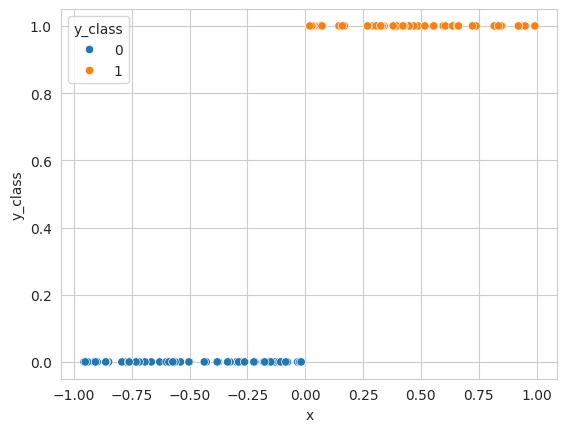

In [3]:
x = 2*scipy.stats.uniform.rvs(size=100)-1
y = np.array([ response(x[i]) for i in range(len(x)) ])

data = pd.DataFrame({'x': x, 'y_class': y})

sns.scatterplot(x='x', y="y_class", data=data, hue='y_class')

We plot the distribution of values of feature $x$ for the two classes separately:

/tmp/ipykernel_19/147547088.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.query('y_class==0')[['x']])
/tmp/ipykernel_19/147547088.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.query('y_class==1')[['x']])


Text(0.5, 0, 'X')

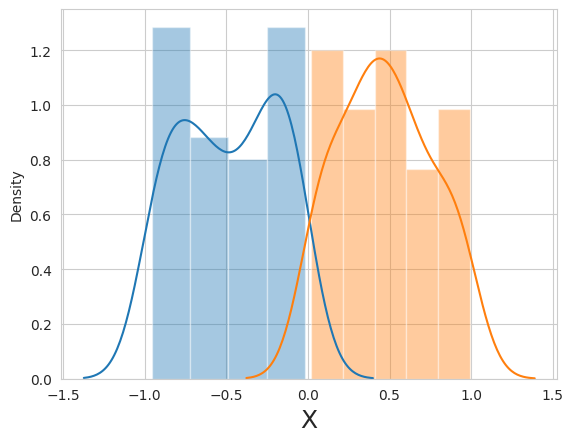

In [4]:
sns.distplot(data.query('y_class==0')[['x']])
sns.distplot(data.query('y_class==1')[['x']])
plt.xlabel('X', fontsize=18)

Using the conditional probability $P(Y=1|X)$ as dependent variable, we can formulate a regression problem. We need a function that maps the real-valued output of a linear regression model to a probability, i.e. values in the range from 0 to 1. We can use the logistic function. In `scipy` this function is implemented as [`expit`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.expit.html) in the module `scipy.special`.

For a given slope and intercept that we pass as arguments to the logistic function, we get a sigmoid-shape function that assumes values in $[0, 1]$.


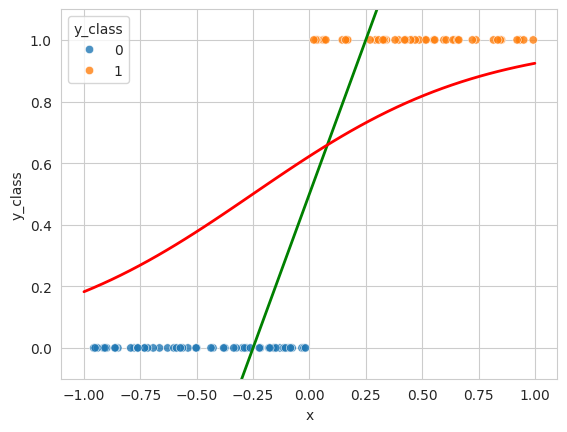

In [5]:
intercept = 0.5
slope = 2

sns.scatterplot(x='x', y="y_class", data=data, alpha=0.8, hue='y_class')
xx = np.linspace(-1, 1, 50)
plt.ylim(-0.1,1.1)
plt.plot(xx, intercept+slope*xx, c='green', lw=2)
plt.plot(xx, expit(intercept+slope*xx), c='red', lw=2)

The logistic function determines the output of the logistic regression model that we use to classify our data. Above, we have illustrated the shape of the function for specific values of the slope and intercept. But how do we learn those parameters from a given training data set?

Taking a statistical inference perspective, we can perform a maximum likelihood estimation. We first need a likelihood function. For given parameters of our model, we then compute the probabilities of the classes based on the logistic function. Multiplying those probabilities for all data in our training sample, we obtain the probability of the data given the model parameters, which we interpret as the likelihood of model parameters given the data. Since we are only interested in the maximum likelihood, we can take the log-likelihhood, which is a monotonic transformation of the function we seek to maximize.

In [6]:
def log_likelihood(beta_0, beta_1, data):
    log_l = 0
    for index, row in data.iterrows():
        x_i = row['x']
        y_i = row['y_class']
        if y_i == 1.0: # we fit the probability for class 1
            log_l += np.log10(expit(beta_0+beta_1*x_i))
        else:
            log_l += np.log10(1-expit(beta_0+beta_1*x_i))
    return log_l

With this function, we can calculate the log-likelihood of different model parameters. We implemented the log-likelihood function such that the logistic function models the probability for class one (not for class zero, which we could have done as well). This means that in our example data set, model parameters that assign probabilities larger than 0.5 for class 1 to features $x>0$ have higher likelihood than models which  probabilities larger than 0.5 for class 1 to features $x<0$.

This property of the logistic model translates to different slope and intercept values of our model, where positive slopes lead to a monotonically increasing logistic function, while we have a decreasing function for negative slopes. We thus expect that the likelihood of a positive slope is much larger than for a negative slope. Let us test this:

-5.728398874630576


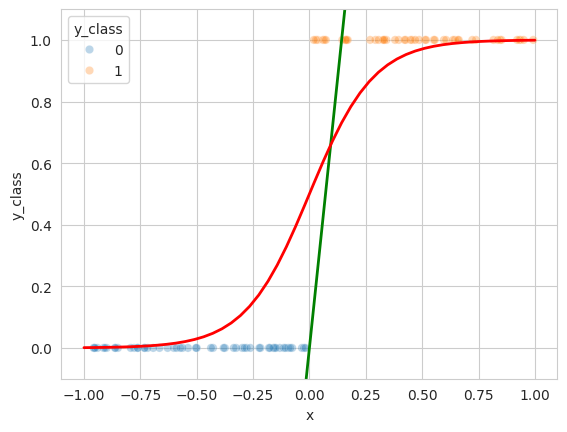

In [7]:
intercept = 0
slope = 7

sns.scatterplot(x='x', y="y_class", data=data, alpha=0.3, hue='y_class')
xx = np.linspace(-1, 1, 50)
plt.ylim(-0.1,1.1)
plt.plot(xx, intercept+slope*xx, c='green', lw=2)
plt.plot(xx, expit(intercept+slope*xx), c='red', lw=2)

print(log_likelihood(intercept, slope, data))

-151.12493156319545


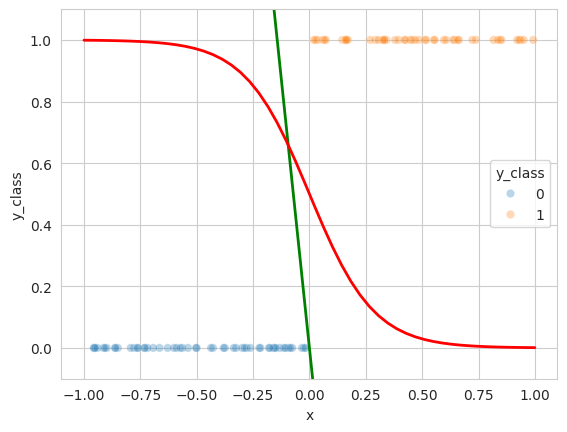

In [9]:
intercept = 0
slope = -7

sns.scatterplot(x='x', y="y_class", data=data, alpha=0.3, hue='y_class')
xx = np.linspace(-1, 1, 50)
plt.ylim(-0.1,1.1)
plt.plot(xx, intercept+slope*xx, c='green', lw=2)
plt.plot(xx, expit(intercept+slope*xx), c='red', lw=2)

print(log_likelihood(intercept, slope, data))

This confirms our intuition. But how do we find the parameters that maximize the log-likelihood? Unlike for linear regression, there is no simple analytical solution for the maximum likelihood estimate. But we can use the partial derivatives of the log-likelihood function to perform a gradient-based algorithm. This algorithm uses the smoothness and convexity of the likelihood manifold in the parameter space of the logistic regression model, moving upwards along the surface of the convex manifold until we reach a maximum.

The following code plots the likelihood manifold for a logistic regression model with a univariate independent variable. Since this model has two parameters, we get a two-dimensional likelihood manifold in a three-dimensional space.

<Figure size 640x480 with 0 Axes>

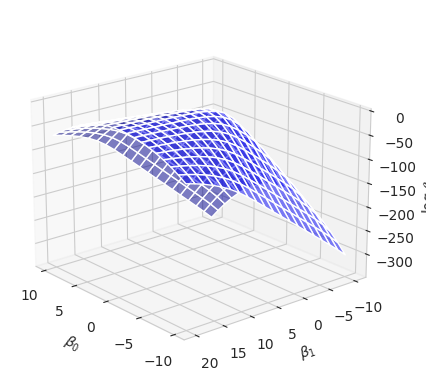

In [10]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot surface that highlights likelihood function in two dimensions (beta_0, beta_1)

# generate mesh in untransformed space X1, X2
beta0_mesh = np.linspace(-10, 10, 20)
beta1_mesh = np.linspace(-10, 20, 20)
beta0_mesh, beta1_mesh = np.meshgrid(beta0_mesh, beta1_mesh)
ax.plot_surface(beta0_mesh, beta1_mesh, log_likelihood(beta0_mesh, beta1_mesh, data), color='blue', alpha=0.5, rstride=1, cstride=1)

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel(r'$\log\mathcal{L}$')
ax.view_init(20, 140)

We can interpret the shape of this manifold and -- in fact -- we could even have predicted it based on the logistic regression model and our data. In our case, the decision boundary is at zero, which means the maximum likelihood solutions for the intercept parameter $\beta_0$ should reside at this point. After all, this is where the output of a linear regression model crosses zero, and thus the logistic function switches between class 0 and class 1.

For the slope $\beta_1$, we see that negative slopes have much smaller likelihoods than positive values, which is due to the fact that (i) we model the probability of class 1, and (ii) all instances of class 1 are right of the instances of class 0. We should thus see a monotonically increasing logistic function, which implies that the slope parameter needs to be positive.

In general, we expect the likelihood to increase as we increase the positive slope, since we make the decision boundary between the two classes sharper. In the particular example above, the classes in the training data set are furthermore separable by a simple linear decision boundary. This means that a model that assigns probability one for class one to all instances right from the decision point, and probability zero for class one to all instances left from the decision point has a likelihood of one. This would correspond to a logistic function with infinite positive slope, i.e. a step function where the probability switches from zero to one at the decision boundary. This implies that in this example, we do not have a unique solution.

## Gradient-based Likelihood Optimization

We can use a gradient ascend algorithm to estimate the optimal parameters heuristically. For this, we must implement the two partial derivatives of the log-likelihood function that we calculated in the lecture.

In [11]:
def partial_beta_0(beta_0, beta_1, data):
    r = 0
    for index, row in data.iterrows():
        x_i = row['x']
        y_i = row['y_class']
        r += y_i - expit(beta_0+beta_1*x_i)
    return r

def partial_beta_1(beta_0, beta_1, data):
    r = 0
    for index, row in data.iterrows():
        x_i = row['x']
        y_i = row['y_class']
        r += x_i * (y_i - expit(beta_0+beta_1*x_i))
    return r

For a given point, these two partial derivatives tell us the direction of the maximum. We then gradually move up the likelihood manifold, until the gradients are zero (i.e. we have reached a local maximum) or the change of the move is smaller than a given threshold. In each step, we move a distance of gamma along the partial derivatives at the current point in the parameter space and we perform a maximum of 1000 iterations before we stop.

In [12]:
def estimate_gradient_ascent(data, initial_params=(0,0), gamma = 0.01, tol = 1e-8, max_iter=1000):
    fitted_beta_0 = initial_params[0]
    fitted_beta_1 = initial_params[1]

    path_beta_0 = []
    path_beta_1 = []
    path_loglikelihood = []

    for i in range(max_iter):
        last_beta_0 = fitted_beta_0
        last_beta_1 = fitted_beta_1
        path_beta_0.append(last_beta_0)
        path_beta_1.append(last_beta_1)
        path_loglikelihood.append(log_likelihood(last_beta_0, last_beta_1, data))
        
        # move up the gradient for both parameters
        fitted_beta_0 = last_beta_0 + gamma * partial_beta_0(last_beta_0, last_beta_1, data)
        fitted_beta_1 = last_beta_1 + gamma * partial_beta_1(last_beta_0, last_beta_1, data)
        step_beta_0 = fitted_beta_0 - last_beta_0
        step_beta_1 = fitted_beta_1 - last_beta_1
        if abs(step_beta_0) <= tol and abs(step_beta_1) <= tol:
            break
    return fitted_beta_0, fitted_beta_1, path_beta_0, path_beta_1, path_loglikelihood

Let us start at a point that we know has very small likelihood, i.e. a point where both the slope and the intercept are negative.

In [13]:
beta_0, beta_1, path_beta_0, path_beta_1, path_loglikelihood = estimate_gradient_ascent(data, (-10, -10))

print(beta_0)
print(beta_1)

-0.11435283895057032
13.648172435476402


Conveniently, the gradient ascent implementation above also returns the path in the likelihood landscape that we gradient ascent has taken. We can plot this path on the two-dimensional likelihood manifold:

<Figure size 640x480 with 0 Axes>

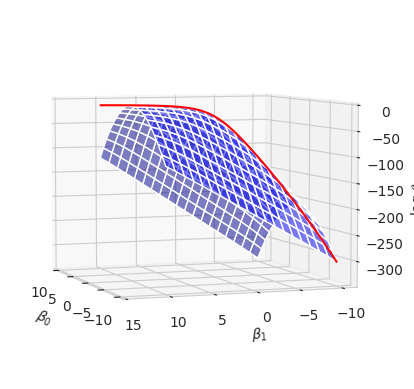

In [14]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

beta0_mesh = np.linspace(-10, 10, 20)
beta1_mesh = np.linspace(-10, 10, 20)
beta0_mesh, beta1_mesh = np.meshgrid(beta0_mesh, beta1_mesh)
ax.plot_surface(beta0_mesh, beta1_mesh, log_likelihood(beta0_mesh, beta1_mesh, data), color='blue', alpha=0.5, rstride=1, cstride=1)
ax.plot3D(path_beta_0, path_beta_1, path_loglikelihood, color='red')

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel(r'$\log\mathcal{L}$')
ax.view_init(5, 160)

We can now plot the fitted logistic function as well as the fitted linear log-odds function. The decision boundary is given by the point at which the logistic function crosses 0.5, which coincides with the point at which the log-odds function crosses zero. For all data points right of that boundary we predict the class 1, for all points left of that boundary we predict class 0. We implement this in terms of a predict function and we plot the predictions:

In [15]:
def predict(beta_0, beta_1, x):
    if expit(beta_0 + x * beta_1)>0.5:
        return 1
    else:
        return 0

-0.11435283895057032
13.648172435476402
-3.0195648907357997


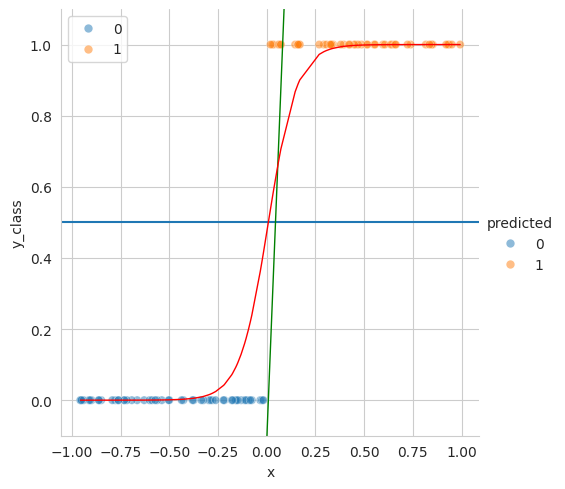

In [16]:
xx = data['x']
data['predicted'] = [ predict(beta_0, beta_1, x) for x in xx]
sns.relplot(x='x', y="y_class", hue='predicted', data=data, alpha=0.5)

plt.axhline(0.5)
plt.ylim(-0.1, 1.1)
sns.lineplot(x=data['x'], y=beta_0 + x * beta_1, color='green', linewidth=1)
sns.lineplot(x=data['x'], y=expit(beta_0 + x * beta_1).ravel() , color='red', linewidth=1)

print(beta_0)
print(beta_1)
print(log_likelihood(beta_0, beta_1, data))

## Logistic regression in scikit-learn

Now that we have implemented the logistic regression model ourselves, we can also use the implementation of logistic regression in scikit-learn, which is provided in the class `LogisticRegression`. Among others, it takes parameters that influence the heuristic algorithm (in the example below we use the gradient-based search algorithm L-BFGS) to estimate the parameters:

-0.6581899096202384
581.251175036077
-1.9290927862832943e-05


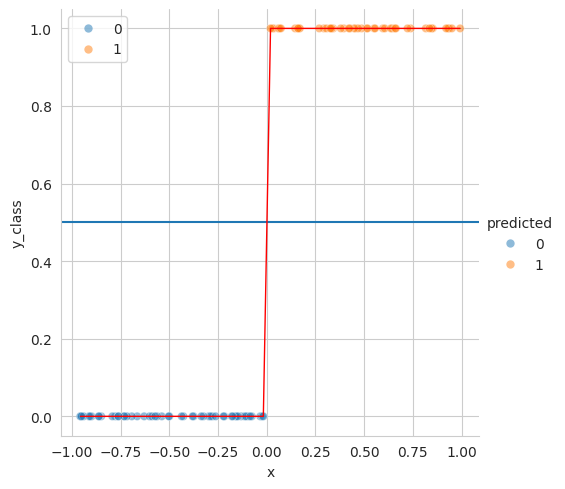

In [19]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-8, penalty=None)

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(data[['x']], data['y_class'])
data['predicted'] = logreg.predict(data[['x']])

sns.relplot(x='x', y="y_class", hue='predicted', data=data, alpha=0.5)
plt.axhline(0.5)
sns.lineplot(x=data['x'], y=expit(x * logreg.coef_ + logreg.intercept_).ravel() , color='red', linewidth=1)

print(logreg.intercept_[0])
print(logreg.coef_[0,0])
print(log_likelihood(logreg.intercept_[0], logreg.coef_[0][0], data))

We obtain a similar decision boundary around zero and an increasing logistic function with positive slope. The solution of scikit-learn actually returns a larger slope than our naive implementation of gradient-based optimization, which is associated with a larger likelihood.